### Returns을 찍어보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats

In [2]:
mktcap = pd.read_pickle("ryu_mktcap.pickle")
price  = pd.read_pickle("ryu_price.pickle")

In [3]:
def draw_return_result(return_df, 
                       freq:str):
    '''return을 주면 결과를 리포트 합니다,
       freq에 Weekly, Daily, 3days 등 넣어줘야함(plot title에 들어감)'''
    fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                             gridspec_kw={'height_ratios': [4, 1, 1]})
    cum_df = (return_df+1).cumprod()
    cum_df.plot(ax=axes[0])
    axes[0].set_title("Cummulative {} returns weighted by marketcap".format(freq))
    axes[0].grid()

    peak = cum_df.cummax()
    drawdown = (cum_df - peak)/peak
    drawdown.plot(ax=axes[1])
    axes[1].set_title("Draw Down")
    axes[1].grid()

    return_df.plot(ax=axes[2])
    axes[2].set_title("{} Returns".format(freq))
    axes[2].grid();
    
    
def cross_sectional_momentum_quintile(return_df:pd.DataFrame, 
                                      mktcap_df:pd.DataFrame,
                                      num_of_coin_in_group:int,
                                      return_num = False):
    rtn = return_df.copy()
    mktcap = mktcap_df.copy()
    return_dict = {}
    
    quintile = [0.2, 0.4, 0.6, 0.8]
    thresh = rtn.apply(lambda x: np.nanquantile(x,quintile),
                       axis=1)
    t1 = thresh.apply(lambda x: x[0])
    t2 = thresh.apply(lambda x: x[1])
    t3 = thresh.apply(lambda x: x[2])
    t4 = thresh.apply(lambda x: x[3])
    
    # Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
    first = rtn.apply(lambda x: x <= t1, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    second= rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    third = rtn.apply(lambda x: (t2 < x) & (x <= t3), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    four =  rtn.apply(lambda x: (t3 < x) & (x <= t4), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    five =  rtn.apply(lambda x: x > t4, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
                      
    # 횡단면 코인 개수가 그룹별로  num_of_coin_in_group이 넘는 날짜를 출력하자                  
    num_coin = pd.concat([first.sum(1), second.sum(1), third.sum(1), 
                          four.sum(1), five.sum(1)], axis=1)
    
    slice = num_coin[num_coin > num_of_coin_in_group].dropna(axis=0)
    start_date = slice.index[0]
    print("{}에서부터 수익률을 계산".format(start_date))          
            
    # 그룹별로 시가총액 weight를 계산
    weight_1 = (first * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_2 = (second* mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_3 = (third * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_4 = (four  * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_5 = (five  * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    
    rtn1 = ((rtn * weight_1.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn2 = ((rtn * weight_2.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn3 = ((rtn * weight_3.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn4 = ((rtn * weight_4.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn5 = ((rtn * weight_5.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    
    return_dict["Q1"] = rtn1 
    return_dict["Q2"] = rtn2 
    return_dict["Q3"] = rtn3 
    return_dict["Q4"] = rtn4 
    return_dict["Q5"] = rtn5 

    if return_num:
        return_dict["count"] = num_coin.loc[start_date:].iloc[:-1]
    return return_dict


def cross_sectional_momentum_terciles(return_df:pd.DataFrame, 
                                      mktcap_df:pd.DataFrame,
                                      num_of_coin_in_group:int,
                                      return_num = False):
    rtn = return_df.copy()
    mktcap = mktcap_df.copy()
    return_dict = {}
    
    quintile = [1/3, 2/3]
    thresh = rtn.apply(lambda x: np.nanquantile(x,quintile),
                       axis=1)
    t1 = thresh.apply(lambda x: x[0])
    t2 = thresh.apply(lambda x: x[1])
    
    # Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
    first = rtn.apply(lambda x: x <= t1, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    second= rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    third = rtn.apply(lambda x: t2 < x, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
                      
    # 횡단면 코인 개수가 그룹별로  num_of_coin_in_group이 넘는 날짜를 출력하자                  
    num_coin = pd.concat([first.sum(1), second.sum(1), third.sum(1)],
                         axis=1)
    
    slice = num_coin[num_coin > num_of_coin_in_group].dropna(axis=0)
    start_date = slice.index[0]
    print("{}에서부터 수익률을 계산".format(start_date))          
            
    # 그룹별로 시가총액 weight를 계산
    weight_1 = (first * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_2 = (second* mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    weight_3 = (third * mktcap).apply(lambda x: x / np.nansum(x), axis=1)
    
    rtn1 = ((rtn * weight_1.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn2 = ((rtn * weight_2.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    rtn3 = ((rtn * weight_3.shift(1)).loc[start_date:].iloc[:-1].sum(1))
    
    return_dict["Q1"] = rtn1 
    return_dict["Q2"] = rtn2 
    return_dict["Q3"] = rtn3 

    if return_num:
        return_dict["count"] = num_coin.loc[start_date:].iloc[:-1]
    return return_dict


def calculate_cagr(return_df):
    '''수익률 df를 주면 CAGR을 계산합니다'''
    holding_year = (len(return_df) / 52)
    cum = (return_df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    print(f"The CAGR is {cagr:.2%}")
    return cagr


def run_alpha_regression(return_df, mktrtn_df, constant=True):
    '''add_constant : True(Default)/ False'''
    tmp_mktrtn = mktrtn_df.copy()
    # 둘의 time-series를 맞춰줍니다
    idx = return_df.index
    tmp_mktrtn = tmp_mktrtn.loc[idx]
    
    if constant:
        model = OLS(return_df, add_constant(tmp_mktrtn))
    else:
        model = OLS(return_df, tmp_mktrtn)
    result = model.fit()
    return result.summary2()

In [4]:
# pct를 구해줌
pct = price.pct_change(fill_method=None)
pct_3days = price.pct_change(3, fill_method=None) \
               .resample("3D").first()
pct_weekly = price.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총 weights 계산
mktcap_3days = mktcap.resample("3D").first()
mktcap_weekly = mktcap.resample("W").first()

weight_daily = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
weight_3days = mktcap_3days.apply(lambda x: x/ np.nansum(x), axis=1)
weight_weekly = mktcap_weekly.apply(lambda x: x/ np.nansum(x), axis=1)

# nan처리를 위한 masking 생성
sign_daily = np.sign(price)
sign_3days = np.sign(price.loc[pct_3days.index[:-1]])
sign_weekly = np.sign(price.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
rtn_daily = sign_daily * pct
rtn_3days = sign_3days * pct_3days
rtn_weekly = sign_weekly * pct_weekly

# 마켓 리턴

In [5]:
# 리턴 계산
## 주간 마켓 리턴
mktrtn_weekly = ((rtn_weekly * weight_weekly.shift(1)).sum(axis=1))
## 3days 마켓 리턴
mktrtn_3days = ((rtn_3days * weight_3days.shift(1)).sum(axis=1))
## daily 마켓 리턴
mktrtn_daily = ((rtn_daily * weight_daily.shift(1)).sum(axis=1))

In [ ]:
#draw_return_result(mktrtn_weekly, "Weekly")

# 5분위수(모멘텀 기준)

In [6]:
five_group_weekly = cross_sectional_momentum_quintile(rtn_weekly, 
                                                      mktcap_weekly,
                                                      18, True)
five_group_daily = cross_sectional_momentum_quintile(rtn_daily, 
                                                     mktcap,
                                                     19, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


2017-06-11 00:00:00에서부터 수익률을 계산


c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


2017-06-06 00:00:00에서부터 수익률을 계산


In [13]:
(five_group_weekly["Q4"] + 1)#.cumprod().plot(figsize=(24,12))
#plt.grid()

2017-06-11    1.243640
2017-06-18    1.666743
2017-06-25    1.155784
2017-07-02    0.891159
2017-07-09    0.892891
                ...   
2023-02-05    1.018460
2023-02-12    1.043995
2023-02-19    0.925947
2023-02-26    1.005559
2023-03-05    0.952175
Length: 300, dtype: float64

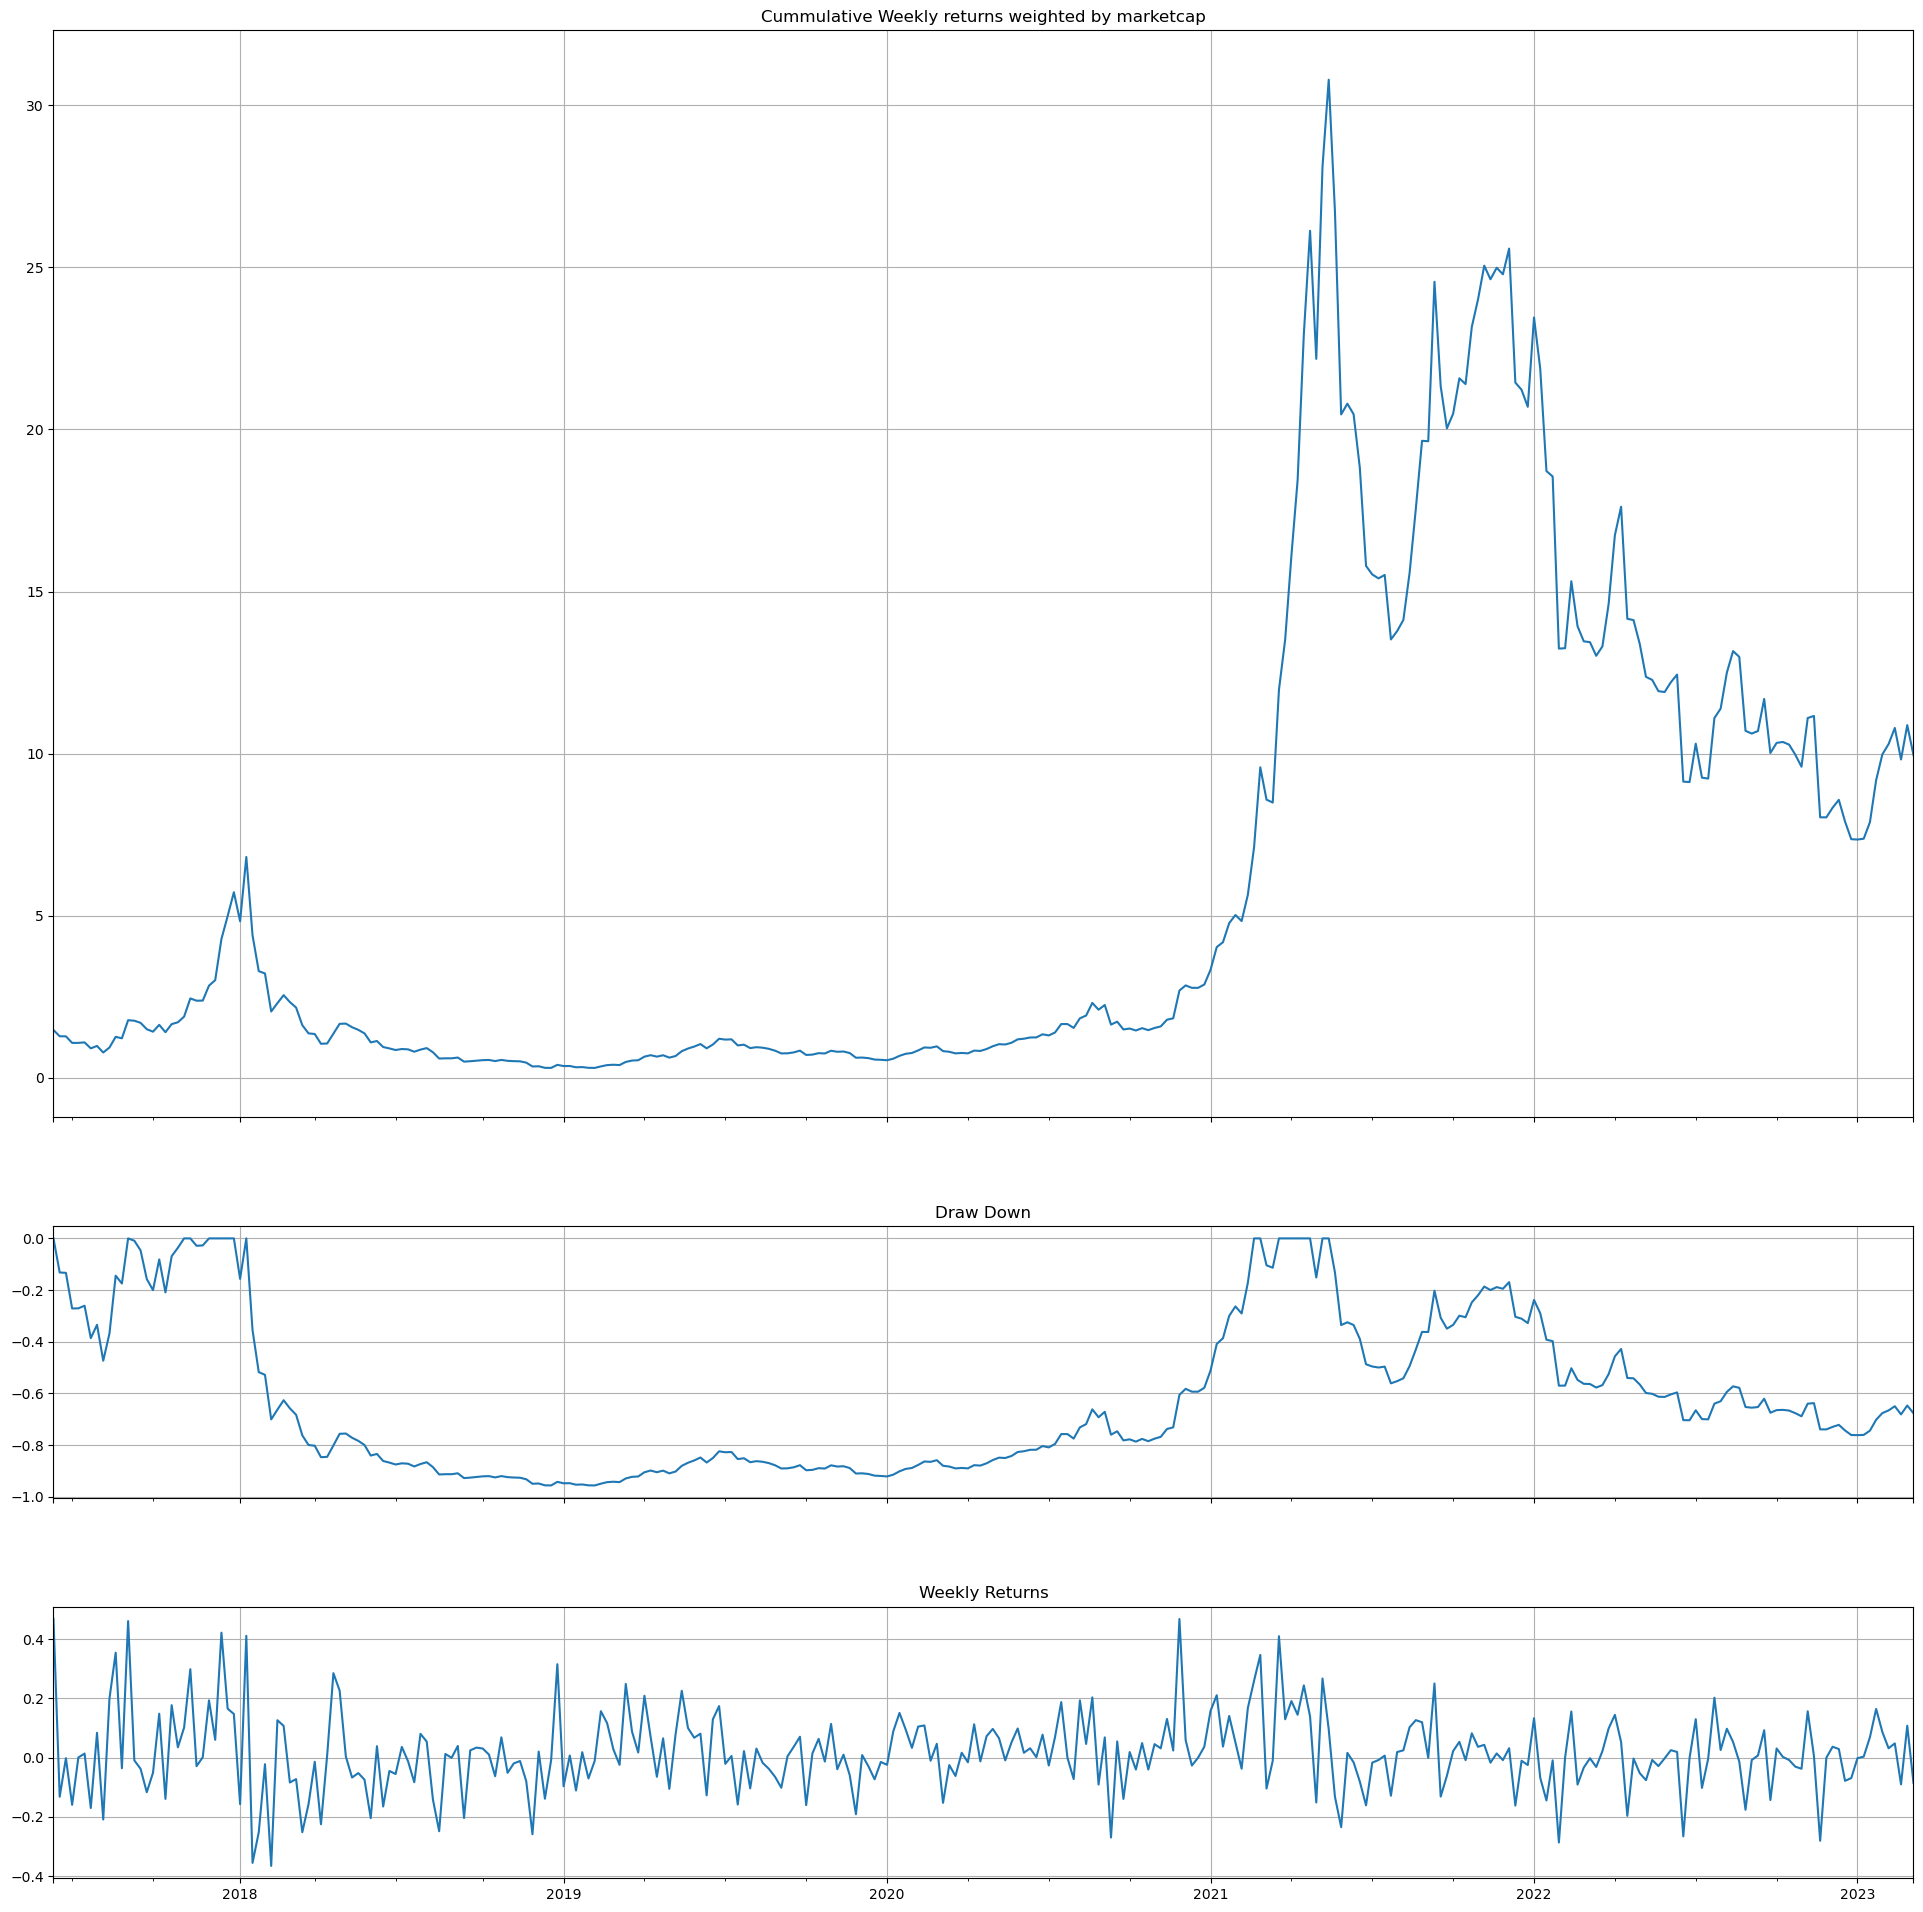

In [24]:
draw_return_result(five_group_weekly["Q5"], freq="Weekly")

In [ ]:
# loc[:"2018"]을 없애면 포폴이 음수를 찍는 날이 나온다
q5q1 = (five_group_weekly["Q5"] - five_group_weekly["Q1"])
#draw_return_result(q5q1, "Daily")

통계량 찍어보자 / cov_type='HAC',cov_kwds={'maxlags':1}

In [9]:
five_group_weekly["Q1"]

2017-06-11    0.291970
2017-06-18    0.086524
2017-06-25    0.056996
2017-07-02   -0.112491
2017-07-09    0.006934
                ...   
2023-02-05    0.056856
2023-02-12    0.049437
2023-02-19   -0.071851
2023-02-26    0.164346
2023-03-05   -0.003656
Length: 300, dtype: float64

In [22]:
run_alpha_regression(five_group_weekly["Q3"],mktrtn_weekly)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.784    
Dependent Variable: y                AIC:                -843.2443
Date:               2023-03-25 16:13 BIC:                -835.8368
No. Observations:   300              Log-Likelihood:     423.62   
Df Model:           1                F-statistic:        1085.    
Df Residuals:       298              Prob (F-statistic): 2.57e-101
R-squared:          0.784            Scale:              0.0034988
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const       -0.0003     0.0034   -0.0827   0.9341   -0.0070   0.0065
0            1.0448     0.0317   32.9337   0.0000    0.9823   1.1072
------------------------------------------------------------------
Omnibus:              217.941      Durbin-Watson:         1.609   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      4796.229
Skew:                 2.638        Prob(JB):              0.000   
Kurtosis:             21.864       Condition No.:         9       
==================================================================

"""

# 3분위수로 계산

In [ ]:
terciles_result = cross_sectional_momentum_terciles(rtn_daily, mktcap,
                                                    19, True)

In [ ]:
terciles_result["count"]

In [ ]:
draw_return_result(terciles_result["Q3"], "Daily")

In [ ]:
terciles_result['count']

In [ ]:
model = OLS(rtn5, 
            add_constant(result1.loc[start_date:] \
                                .iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date:].iloc[:-1],
            rtn2)
plt.xlabel("MKT Return")
plt.ylabel("Return of Q5");

In [ ]:
model = OLS(rtn_s, 
            add_constant(result1.loc[start_date2:].iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date2:].iloc[:-1],
            rtn_h)
plt.xlabel("MKT Return")
plt.ylabel("Return of H");
#plt.ylim(-0.7,1.5);

In [ ]:
mkt_sample = result1.loc[start_date:].iloc[:-1]

In [ ]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("G1:", rtn1.mean().round(4), rtn1.std(ddof=1))
print("G2:", rtn2.mean().round(4), rtn2.std(ddof=1))
print("G3:", rtn3.mean().round(4), rtn3.std(ddof=1))
print("G4:", rtn4.mean().round(4), rtn4.std(ddof=1))
print("G5:", rtn5.mean().round(4), rtn5.std(ddof=1))

t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)
t, p_val

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn1)
calculate_cagr(rtn2)
calculate_cagr(rtn3)
calculate_cagr(rtn4)
calculate_cagr(rtn5)

In [ ]:
concat_df = pd.concat([rtn1, rtn2, rtn3, rtn4 , rtn5, mkt_sample], 
                      axis=1)
concat_df.columns = ["One","Two","Three","Four","Five","MKT"]

concat_df.corr()

In [ ]:
# 3개 그룹의 결과를 뽑자
mkt_sample2 = result1.loc[start_date2:].iloc[:-1]
rtn_s_sample = rtn_s.loc[start_date2:]
rtn_m_sample = rtn_m.loc[start_date2:]
rtn_h_sample = rtn_h.loc[start_date2:]

In [ ]:
print("S:", rtn_s_sample.mean().round(4), rtn_s_sample.std(ddof=1))
print("M:", rtn_m_sample.mean().round(4), rtn_m_sample.std(ddof=1))
print("H:", rtn_h_sample.mean().round(4), rtn_h_sample.std(ddof=1))

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample2)

print("----------------")
print("Group Return")
calculate_cagr(rtn_s_sample)
calculate_cagr(rtn_m_sample)
calculate_cagr(rtn_h_sample)

In [ ]:
concat_df2 = pd.concat([rtn_s_sample, rtn_m_sample,
                        rtn_h_sample, mkt_sample2], 
                       axis=1)
concat_df2.columns = ["Low","Middle","High","MKT"]

concat_df2.corr()

In [ ]:
t, p_val = stats.ttest_ind(rtn_m_sample, 
                           rtn_h_sample)
t,p_val

In [ ]:
model = OLS(rtn_h_sample, 
            add_constant(mkt_sample2))
                            
model.fit().summary2()

In [ ]:
(result1.loc[start_date2:].iloc[:-1] +1)\
    .cumprod().plot(figsize=(24,12), label="Strategy")
(mkt_sample +1).cumprod().plot(figsize=(24,12),
                               label="MKT")
plt.legend();

* Long-Short 전략

코인 롱숏은 숏 한방을 얻어 맞고 죽는듯.....